# Weather Forecast LSTM Model Training
## Variabel: Tekanan Permukaan (PS)
#### Pujo Prayogo 140810200038 <br>

Best Hyperparameter: <br>
    LSTM Layers   : <br> 
    Unit          : <br>
    Activation    : <br>
    Learning Rate : <br>
    MAE (Tuning)  : <br>

R2 Score      : <br>
MAPE Score    : %

In [1]:
import pandas as pd
import numpy as np
import keras_tuner
import requests
import json
import matplotlib.pyplot as plt
import keras_tuner as kt
import model
import shutil
import os

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf

from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Import Data

1. Define fitur variabel, tanggal, dan koordinat lokasi
2. Import data cuaca melalui data Lokal CSV
3. Rename nama kolom ke Bahasa Indonesia
4. Cek data & data NULL

In [2]:
# ----- Kode Parameter cuaca yang digunakan : GWETROOT, WS10M, PS, PRECTOTCORR, RH2M, T2M
feature = "PS"

# ----- Tanggal dan titik koordinat pengambilan data
start_date = "20200101"
end_date = "20241231"
lat = "-6.18"
long = "106.83"

# ----- Dict perubahan nama kolom 
renamed_dict = {
    "GWETROOT": "Kelembaban_Tanah",
    "WS10M": "Kecepatan_Angin",
    "PS": "Tekanan_Permukaan",
    "PRECTOTCORR": "Presipitasi",
    "RH2M": "Kelembaban_Udara",
    "T2M": "Temperatur"
}

# ----- variabel berisi nama fitur dengan Bahasa
feature_name = renamed_dict[feature]

# ----- Metrics tiap fitur
metrics_dict = {
    "GWETROOT": "", #Hanya 0-1
    "WS10M": "m/s",
    "PS": "kPa",
    "PRECTOTCORR": "mm/day",
    "RH2M": "C",
    "T2M": "g/kg"
}

# ----- Read data dari CSV 
df = pd.read_csv(f'Jakpus_{feature_name}_2020-2024.csv', sep=';', encoding='utf-8-sig')

# ----- Buat kolom tanggal dari YEAR dan DOY
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str), format='%Y') + pd.to_timedelta(df['DOY'] - 1, unit='D')

# ----- Menjadikan DATE sebagai index, Hapus nama index
df.set_index('DATE', inplace=True)
df.index.name = None

# ----- Hapus kolom YEAR dan DOY
df.drop(columns=['YEAR', 'DOY'], inplace=True)

# ----- Rename kolom sesuai kebutuhan
df.rename(columns={feature: feature_name}, inplace=True)

# ----- Cek Data
print(df.info(), '\n')
print(df, '\n\n')

# ----- Cek Data Invalid (Bernilai -999)
invalid_data = (df == -999).sum().sum()
print("TIDAK ADA DATA INVALID" if invalid_data == 0 else f"TERDAPAT DATA INVALID SEBANYAK {invalid_data} DATA")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Tekanan_Permukaan  1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None 

            Tekanan_Permukaan
2020-01-01             101.02
2020-01-02             101.07
2020-01-03             100.93
2020-01-04             100.75
2020-01-05             100.78
...                       ...
2024-12-27             100.93
2024-12-28             100.90
2024-12-29             100.86
2024-12-30             100.90
2024-12-31             100.80

[1827 rows x 1 columns] 


TIDAK ADA DATA INVALID


#### Visualisasi data dalam grafik
Menampilkan grafik sebaran data asli sebelum difilter

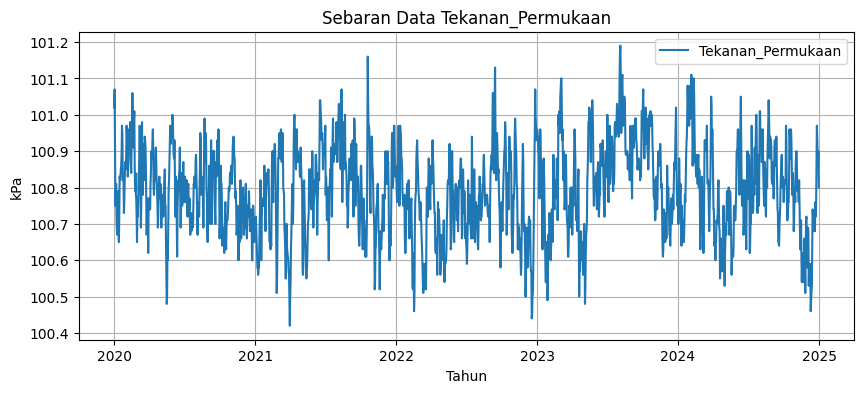

In [3]:
# ----- Visualisasi Data Asli
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[feature_name], label=feature_name)
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Sebaran Data {feature_name}')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# ----- Jika Import Data melalui API POWER NASA
#request_url = (
#    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
#    f"start={start_date}&end={end_date}&latitude={lat}&longitude={long}&community=ag&"
#    f"parameters={feature}&format=json&user=pujo&header=true&time-standard=lst"
#)
#response = requests.get(url=request_url, verify=True, timeout=30.00)
#content = json.loads(response.content.decode('utf-8'))

# ----- Konversi data ke DataFrame
#df = pd.DataFrame.from_dict(content['properties']['parameter'])
#df.index = pd.to_datetime(df.index, format='%Y%m%d')

# ----- Rename Kolom
#df.rename(columns={feature: feature_name}, inplace=True)

# Data Cleaning (IQR)

Menghilangkan data yang tidak berada di antara lower bound dan upper bound (LB <= X >= UB)

In [5]:
# ------ impan Data asli sebelum terfilter untuk berjaga-jaga
df_real = df

# ----- IQR Data cleaning
Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

# ----- Menghapus outlier di luar 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR # (0.25)
upper_bound = Q3 + 1.5 * IQR # (0.75)
# ----- Print Outliers
outliers = df[(df[feature_name] <= lower_bound) | (df[feature_name] >= upper_bound)]
print(f"Outliers terhapus: {outliers.shape[0]} data ({(outliers.shape[0] / df.shape[0]) * 100:.2f}%)")
print(outliers.head())

df = df[(df[feature_name] >= lower_bound) & (df[feature_name] <= upper_bound)] # Df = Lowerbound >= DF <= Upperbound
print(f'data terfilter : {df}')

Outliers terhapus: 6 data (0.33%)
            Tekanan_Permukaan
2021-03-31             100.42
2021-10-19             101.16
2022-12-18             100.44
2022-12-19             100.45
2023-08-04             101.19
data terfilter :             Tekanan_Permukaan
2020-01-01             101.02
2020-01-02             101.07
2020-01-03             100.93
2020-01-04             100.75
2020-01-05             100.78
...                       ...
2024-12-27             100.93
2024-12-28             100.90
2024-12-29             100.86
2024-12-30             100.90
2024-12-31             100.80

[1821 rows x 1 columns]


## Autokorelasi 
Menampilkan grafik autokorelasi dengan acf untuk menentukan timesteps. <br>
Timesteps yang diambil : <b>40

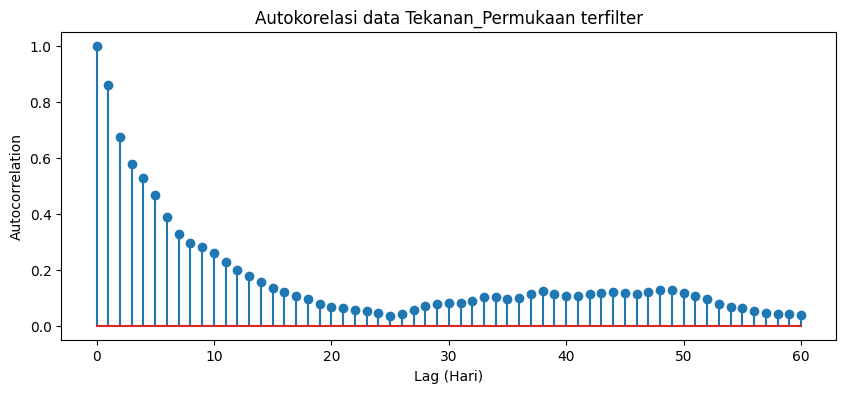

In [6]:
# ----- Autokorelasi untuk menentukan TImesteps
def determine_timesteps(df, max_lag=60):
    lag_acf = acf(df[feature_name], nlags=max_lag)

    # Visualisasi autokorelasi
    plt.figure(figsize=(10, 4))
    plt.stem(range(len(lag_acf)), lag_acf)
    plt.title(f'Autokorelasi data {feature_name} terfilter')
    plt.xlabel('Lag (Hari)')
    plt.ylabel('Autocorrelation')
    plt.show()

    return lag_acf

autocorrelation = determine_timesteps(df)

### Visualisasi Data yang telah terfilter & hasil Splitting 8:2

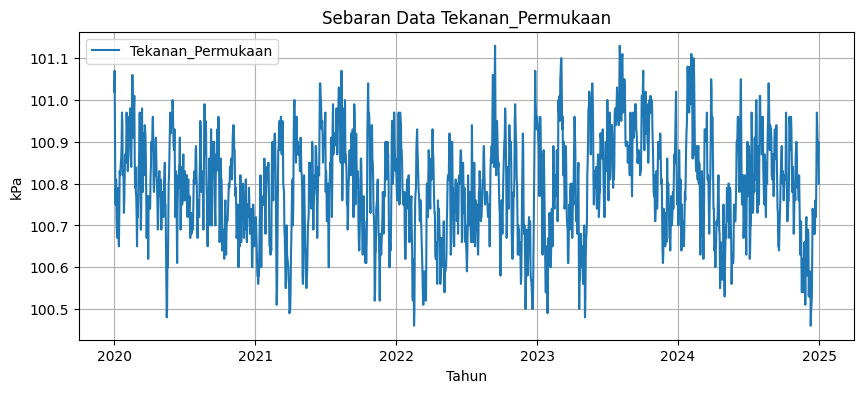

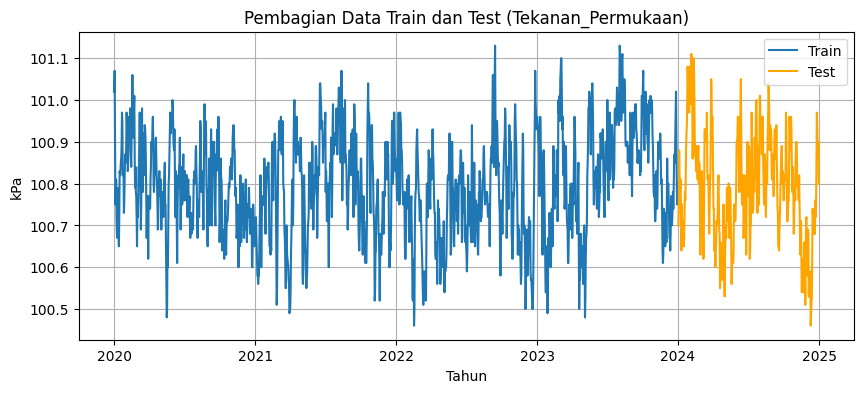

In [7]:
# ----- Visualisasi Data
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[feature_name], label=feature_name)
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])  # Y-axis dinamis sesuai parameter
plt.title(f'Sebaran Data {feature_name}')
plt.grid(True)
plt.legend()
plt.show()

# ----- Visualisasi Train-Test Split Data Asli
X_train, X_test, y_train, y_test = train_test_split(
    df, df, test_size=0.2, shuffle=False
)

plt.figure(figsize=(10, 4))
plt.plot(df.index[:len(X_train)], X_train, label='Train')
plt.plot(df.index[len(X_train):], X_test, label='Test', color='orange')
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Pembagian Data Train dan Test ({feature_name})')
plt.grid(True)
plt.legend()
plt.show()

## Data Scaling & Splitting 

1. Scaling dengan MinMax
2. Pembagian data menjadi data Training (80%) dan data Testing (20%) tanpa mengubah urutan data

x' = x - min(x) / max(x) - min(x) <br>
x = Data original

In [8]:
# ----- Normalisasi Data 
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# ----- Fungsi untuk Membuat Data Time-Series 
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# ----- Membuat Data Train & Test 
time_steps = 40  # Jumlah lag (window size)
X, y = create_sequences(df_scaled, time_steps)
split = int(0.8 * len(X))  # 80% Train, 20% Test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ----- RESHAPE agar cocok untuk input LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ------ Simpan urutan terakhir dari dataset yang akan digunakan untuk prediksi masa depan
X_last_sequence = df_scaled[-time_steps:]

#### Membuat Directory untuk menyimpan hasil Tuning (Overwrite jika sudah ada) 

In [9]:
# ----- Hapus Directory Tuning (hanya untuk Tuning ulang)
#tuning_dir = f'lstm_tuning_{feature_name}_cleaned_dir'

#if os.path.exists(tuning_dir):
#    shutil.rmtree(tuning_dir)
#    print(f"Directory file Tuning sebelumnya yang Terhapus: {tuning_dir}")
#else:
#     print(f"Directory File Tuning {tuning_dir} tidak ditemukan")

# Hyperparameter Tuning dengan KerasTuner
1. Membuat fungsi model LSTM:
   - Tuning jumlah layer LSTM (1 atau 2).
    - Tuning jumlah unit per layer (32, 64, atau 128).
    - Tuning fungsi aktivasi (relu, tanh, atau sigmoid).
    - Tuning optimizer (adam atau rmsprop) dan learning rate (0.01 atau 0.001).
2. Menambah Dropout (0.2) untuk mencegah overfitting
3. Inisiasi Tuner dengan trials sebanyak 72 kombinasi dan 1 eksekusi/trial
4. Mengaplikasikan callback EarlyStopping untuk menghentikan pelatihan jika tidak terdapat perbaikan selama 15 epochs berturut-turut

In [10]:
# ----- Fungsi untuk membangun model untuk tuning
def build_model(hp): 
    model = Sequential()

    # ----- Opsi Hyperparameters yang digunakan 
    for i in range(hp.Choice('layers', [1, 2])):
        model.add(LSTM(
            units=hp.Choice('units', [32, 64, 128]),
            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),
            return_sequences=(i < hp.Choice('layers', [1, 2]) - 1),
            input_shape=(time_steps, 1) if i == 0 else None
        ))
        model.add(Dropout(0.2))
    
    model.add(Dense(1))
    
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', [0.01, 0.001])
    
    optimizer = Adam(learning_rate=lr) if opt_choice == 'adam' else RMSprop(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ----- Callback untuk menghentikan training jika tidak ada peningkatan selama 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# ----- Inisiasi tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=72,
    executions_per_trial=1,
    directory=f'lstm_tuning_{feature_name}_cleaned_dir',
    project_name=f'lstm_{feature_name}_cleaned_tuning'
)

# ----- Hyperparameter Search : Epochs 200
tuner.search(X_train, y_train, epochs=200, batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping])

# ----- Mengambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# ----- Train ulang model terbaik untuk digunakan dan disimpan
history = best_model.fit(X_train, y_train, epochs=200, batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])

best_model.save(f'{feature_name}_model.keras')

Reloading Tuner from lstm_tuning_Tekanan_Permukaan_cleaned_dir\lstm_Tekanan_Permukaan_cleaned_tuning\tuner0.json


C:\Users\Pujo Prayogo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.3476 - mae: 0.5569 - val_loss: 0.0254 - val_mae: 0.1289
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0240 - mae: 0.1237 - val_loss: 0.0221 - val_mae: 0.1210
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0215 - mae: 0.1181 - val_loss: 0.0201 - val_mae: 0.1161
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0205 - mae: 0.1149 - val_loss: 0.0215 - val_mae: 0.1180
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0184 - mae: 0.1087 - val_loss: 0.0197 - val_mae: 0.1130
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0167 - mae: 0.1025 - val_loss: 0.0209 - val_mae: 0.1154
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0182 - mae: 0.1084 - val_loss: 0.0172 - val_mae: 0.1052
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0163 - mae: 0.1022 - val_loss: 0.0140 - val_mae: 0.0949
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - lo

#### Output Hyperparameter Tuning (Konfigurasi terbaik & hasil seluruh Trials)

In [11]:
# ----- Output Best Hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner_results = tuner.oracle.get_best_trials(num_trials=72)  
results = []

# Memasukkan Hasil Tuning ke DataFrame
for trial in tuner_results:
    values = trial.hyperparameters.values
    values['score'] = trial.score  # Nilai skor (mae)
    values['layers'] = trial.hyperparameters.get('layers')  # Menambahkan jumlah layer
    results.append(values)

df_results = pd.DataFrame(results)

# Tampilkan semua baris
pd.set_option('display.max_rows', None)  # Tampilkan semua baris
pd.set_option('display.max_columns', None)  # Tampilkan semua kolom

# Print Hyperparameter Terbaik
print("\n--- Setting Hyperparameter Terbaik ---")
print(f"Layer(s): {best_hps.get('layers')}")  # Menambahkan jumlah layer
print(f"Filters (units LSTM): {best_hps.get('units')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Score (MAE): {best_hps.get('score')}\n\n")

# Print seluruh hasil hyperparameter tuning
print('Hasil Hyperparameter Tuning')
print(df_results)


--- Setting Hyperparameter Terbaik ---
Layer(s): 2
Filters (units LSTM): 128
Activation: tanh
Optimizer: adam
Learning Rate: 0.01
Score (MAE): 0.007655553054064512


Hasil Hyperparameter Tuning
    layers  units activation optimizer  learning_rate     score
0        2    128       tanh      adam          0.010  0.007656
1        1     64       tanh      adam          0.010  0.007667
2        2    128       tanh      adam          0.001  0.007700
3        1    128       tanh      adam          0.001  0.007702
4        1     32       tanh   rmsprop          0.001  0.007710
5        2     64       tanh      adam          0.001  0.007713
6        2     32       tanh   rmsprop          0.001  0.007716
7        2     32       tanh      adam          0.001  0.007721
8        1     64       tanh   rmsprop          0.001  0.007723
9        1     32       tanh      adam          0.010  0.007726
10       2     64       relu   rmsprop          0.010  0.007728
11       2     64       tanh      ada

## Evaluasi Model
Evaluasi Model menggunakan metric evaluasi R-Squared dan MAPE

R-Squared = seberapa baik model menjelaskan variasi dalam data
MAPE = tingkat kesalahan prediksi dengan persentase

R2 = 1 - (∑_(i=1)^n〖(yi-y ̂_i)〗^2 ) / (∑_(i=1)^n .〖(y_i-y ̅ )〗^2 ) <br>
MAPE = 1/n ∑_(i=1)^n |(y_i-y ̂_i)/y_i | 

In [12]:
# ----- Prediksi & Evaluasi
y_pred = best_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"R-Squared: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step 
R-Squared: 0.7963
MAPE: 0.0461%


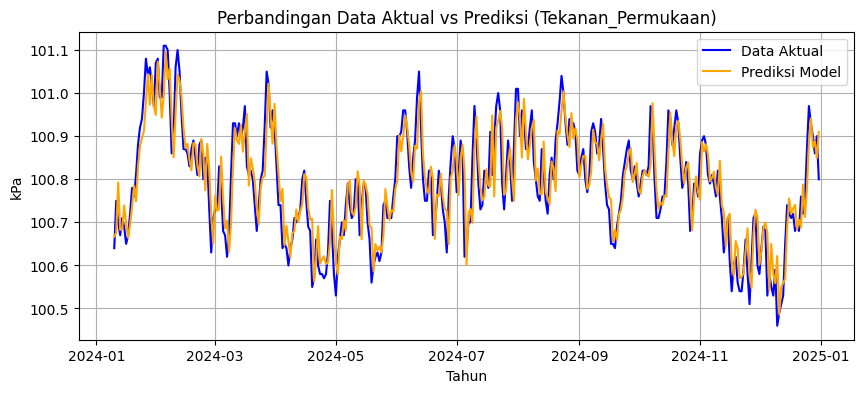

In [16]:
# Ambil tanggal-tanggal dari indeks df yang sesuai dengan y_test
dates = df.index[split + time_steps:]

# Pastikan jumlah tanggal sama dengan panjang y_test
dates = dates[:len(y_test)]

# Plot dengan x = tanggal
plt.figure(figsize=(10, 4))
plt.plot(dates, y_test_inv, label='Data Aktual', color='blue')
plt.plot(dates, y_pred_inv, label='Prediksi Model', color='orange')
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f"Perbandingan Data Aktual vs Prediksi ({feature_name})")
plt.grid(True)
plt.legend()
plt.show()

## Prediksi Data di Masa Depan

1. Membuat fungsi prediksi yang melakukan prediksi data secara berulang menggunakan nilai prediksi sebelumnya
2. Mengembalikan prediksi ke skala aslinya dengan inverse transform (membalikkan normalisasi minmax)

In [14]:
def predict_until(target_date, model, data, scaler, timesteps, initial_date):
    # Buat list tanggal dari hari setelah data terakhir hingga target
    future_dates = pd.date_range(start=initial_date + timedelta(days=1), end=target_date)
    future_steps = len(future_dates)

    # (Opsional) Batas maksimal prediksi (misalnya 1 tahun)
    max_forecast_days = 365
    if future_steps > max_forecast_days:
        raise ValueError(f"Batas prediksi hanya {max_forecast_days} hari")

    # Prediksi berulang
    current_input = data.reshape(1, timesteps, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(current_input, verbose=0)
        future_predictions.append(pred[0])

        # Update input
        current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

    # Inverse transform
    future_predictions_inv = scaler.inverse_transform(future_predictions)

    return future_dates, future_predictions_inv

In [15]:
# Misal tanggal target prediksi adalah 18 Januari 2025
target_date = pd.to_datetime("2025-01-10")

# Prediksi dari hari setelah data terakhir hingga target date
future_dates, future_preds = predict_until(target_date, model, X_last_sequence, scaler, time_steps, df.index[-1])

# Print hasil prediksi di tanggal target
print(f"Prediksi {feature_name} pada {target_date.date()}: {future_preds[-1][0]:.2f} {metrics_dict[feature]}")

AttributeError: module 'model' has no attribute 'predict'

In [ ]:
# Gabungkan data prediksi historis dan masa depan
combined_dates = np.concatenate([df.index[len(X_train) + time_steps:], future_dates])
combined_predictions = np.concatenate([y_pred_inv, future_preds])

# Tanggal awal tampilan (15 hari sebelum awal prediksi masa depan)
start_display = future_dates[0] - pd.DateOffset(days=15)   # Tampilkan n hari sebelumnya
end_display = future_dates[-1] + pd.DateOffset(days=1)

plt.figure(figsize=(10, 5))
plt.plot(df.index[len(X_train) + time_steps:], y_test_inv, label='Data Aktual', color='blue')
plt.plot(future_dates, future_preds, label='Prediksi Masa Depan', color='green')

# Anotasi
plt.annotate(f'{future_preds[-1][0]:.2f} {metrics_dict[feature]}',
             xy=(future_dates[-1], future_preds[-1][0]),
             xytext=(-10, 60),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.title(f"Prediksi {feature_name} Hingga {target_date.date()}")
plt.xlabel("Tanggal")
plt.ylabel(f"{metrics_dict[feature]}")
plt.legend()
plt.grid(True)

# Batasi sumbu X agar hanya tampil sebulan sebelum prediksi
plt.xlim([start_display, end_display])
plt.tight_layout()
plt.show()